In [ ]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.optimizers.legacy import Adam
# Others
import shutil
import random


Load dataset

In [ ]:
# Download dataset
od.download('https://www.kaggle.com/datasets/faudyanurul/tomato')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faudyanurul
Your Kaggle Key: ··········


100%|██████████| 551M/551M [00:06<00:00, 87.7MB/s]


In [ ]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/Tomato/train",
    label_mode="categorical",
    class_names=['Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf healthy', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/Tomato/valid",
    label_mode="categorical",
    class_names=['Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf healthy', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 17195 files belonging to 9 classes.
==========================Validation Data====================
Found 4197 files belonging to 9 classes.


In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("tomato/Tomato/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("tomato/Tomato/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 17195 images belonging to 9 classes.
Found 4197 images belonging to 9 classes.


listResource

In [ ]:
# Check GPU
!nvidia-smi

Sun Jun  4 11:27:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

In [ ]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="DenseNet_model1_Tomato_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)


# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
# Define DIY Model
DenseNet_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(9, activation='softmax') 
  ])


# Compile Model
DenseNet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1024)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 7,302,217
Trainable params: 7,218,569
Non-trainable params: 83,648
_______________________________________

In [ ]:

# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_1 = DenseNet_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
860/860 [==============================] - ETA: 0s - loss: 0.8758 - accuracy: 0.7642
Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DenseNet_model1_Tomato_Based_Non_Augmented


860/860 [==============================] - 358s 327ms/step - loss: 0.8758 - accuracy: 0.7642 - val_loss: 0.2970 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 2/100
860/860 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9093
Epoch 2: val_accuracy did not improve from 0.90255
860/860 [==============================] - 211s 246ms/step - loss: 0.2792 - accuracy: 0.9093 - val_loss: 0.3755 - val_accuracy: 0.8790 - lr: 0.0010
Epoch 3/100
860/860 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.9266
Epoch 3: val_accuracy did not improve from 0.90255
860/860 [==============================] - 214s 249ms/step - loss: 0.2216 - accuracy: 0.9266 - val_loss: 0.3353 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 4/100
860/860 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 0.9334
Epoch 4: val_accuracy improved from 0.90255 to 0.91327, saving model to DenseNet_model1_Tomato_Based_Non_Augmented


860/860 [==============================] - 275s 320ms/step - loss: 0.2034 - accuracy: 0.9334 - val_loss: 0.2604 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 5/100
860/860 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9399
Epoch 5: val_accuracy did not improve from 0.91327
860/860 [==============================] - 215s 250ms/step - loss: 0.1816 - accuracy: 0.9399 - val_loss: 0.7748 - val_accuracy: 0.7994 - lr: 0.0010
Epoch 6/100
860/860 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9456
Epoch 6: val_accuracy improved from 0.91327 to 0.95521, saving model to DenseNet_model1_Tomato_Based_Non_Augmented


860/860 [==============================] - 275s 320ms/step - loss: 0.1664 - accuracy: 0.9456 - val_loss: 0.1449 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 7/100
860/860 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9440
Epoch 7: val_accuracy did not improve from 0.95521
860/860 [==============================] - 214s 248ms/step - loss: 0.1693 - accuracy: 0.9440 - val_loss: 0.1632 - val_accuracy: 0.9435 - lr: 0.0010
Epoch 8/100
860/860 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.9528
Epoch 8: val_accuracy did not improve from 0.95521
860/860 [==============================] - 215s 250ms/step - loss: 0.1408 - accuracy: 0.9528 - val_loss: 0.3320 - val_accuracy: 0.8816 - lr: 0.0010
Epoch 9/100
860/860 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9535
Epoch 9: val_accuracy did not improve from 0.95521
860/860 [==============================] - 215s 250ms/step - loss: 0.1347 - accuracy: 0.9535 - val_loss: 0.4678 

860/860 [==============================] - 281s 327ms/step - loss: 0.1140 - accuracy: 0.9609 - val_loss: 0.1425 - val_accuracy: 0.9564 - lr: 0.0010
Epoch 12/100
860/860 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.9629
Epoch 12: val_accuracy did not improve from 0.95640
860/860 [==============================] - 215s 249ms/step - loss: 0.1104 - accuracy: 0.9629 - val_loss: 0.5234 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 13/100
860/860 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9629
Epoch 13: val_accuracy did not improve from 0.95640
860/860 [==============================] - 214s 249ms/step - loss: 0.1078 - accuracy: 0.9629 - val_loss: 0.1561 - val_accuracy: 0.9547 - lr: 0.0010
Epoch 14/100
860/860 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9657
Epoch 14: val_accuracy did not improve from 0.95640
860/860 [==============================] - 213s 248ms/step - loss: 0.0984 - accuracy: 0.9657 - val_loss: 0

860/860 [==============================] - 275s 320ms/step - loss: 0.1102 - accuracy: 0.9618 - val_loss: 0.1029 - val_accuracy: 0.9716 - lr: 0.0010
Epoch 16/100
860/860 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9692
Epoch 16: val_accuracy did not improve from 0.97165
860/860 [==============================] - 219s 255ms/step - loss: 0.0883 - accuracy: 0.9692 - val_loss: 0.5424 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 17/100
860/860 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9666
Epoch 17: val_accuracy improved from 0.97165 to 0.97665, saving model to DenseNet_model1_Tomato_Based_Non_Augmented


860/860 [==============================] - 274s 319ms/step - loss: 0.0951 - accuracy: 0.9666 - val_loss: 0.0761 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 18/100
860/860 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9710
Epoch 18: val_accuracy did not improve from 0.97665
860/860 [==============================] - 220s 255ms/step - loss: 0.0814 - accuracy: 0.9710 - val_loss: 0.1292 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 19/100
860/860 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9714
Epoch 19: val_accuracy did not improve from 0.97665
860/860 [==============================] - 214s 248ms/step - loss: 0.0840 - accuracy: 0.9714 - val_loss: 0.1276 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 20/100
860/860 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9726
Epoch 20: val_accuracy did not improve from 0.97665
860/860 [==============================] - 219s 254ms/step - loss: 0.0797 - accuracy: 0.9726 - val_loss: 0

860/860 [==============================] - 274s 319ms/step - loss: 0.0373 - accuracy: 0.9860 - val_loss: 0.0337 - val_accuracy: 0.9898 - lr: 1.0000e-04
Epoch 24/100
860/860 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9883
Epoch 24: val_accuracy improved from 0.98975 to 0.99047, saving model to DenseNet_model1_Tomato_Based_Non_Augmented


860/860 [==============================] - 275s 320ms/step - loss: 0.0314 - accuracy: 0.9883 - val_loss: 0.0334 - val_accuracy: 0.9905 - lr: 1.0000e-04
Epoch 25/100
860/860 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9898
Epoch 25: val_accuracy improved from 0.99047 to 0.99095, saving model to DenseNet_model1_Tomato_Based_Non_Augmented


860/860 [==============================] - 281s 327ms/step - loss: 0.0276 - accuracy: 0.9898 - val_loss: 0.0326 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 26/100
860/860 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9908
Epoch 26: val_accuracy did not improve from 0.99095
860/860 [==============================] - 214s 249ms/step - loss: 0.0247 - accuracy: 0.9908 - val_loss: 0.0329 - val_accuracy: 0.9895 - lr: 1.0000e-04
Epoch 27/100
860/860 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9914
Epoch 27: val_accuracy did not improve from 0.99095
860/860 [==============================] - 220s 256ms/step - loss: 0.0226 - accuracy: 0.9914 - val_loss: 0.0361 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 28/100
860/860 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9924
Epoch 28: val_accuracy did not improve from 0.99095
860/860 [==============================] - 214s 249ms/step - loss: 0.0211 - accuracy: 0.9924 -

Text(0.5, 1.0, 'Training and validation loss DIY Model')

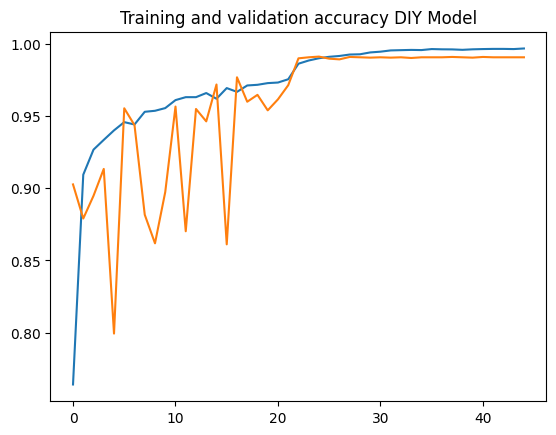

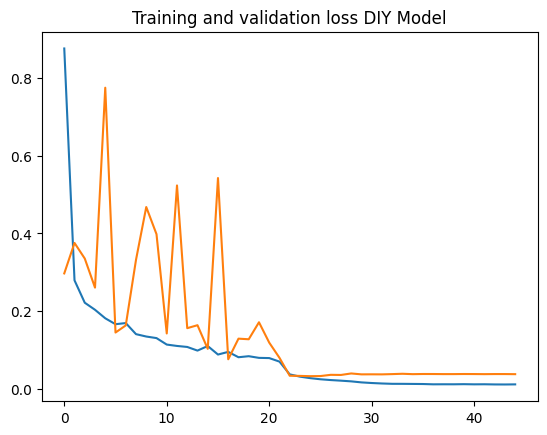

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_1.history['accuracy' ]
val_acc  = history_DenseNet_model_1.history['val_accuracy' ]
loss     = history_DenseNet_model_1.history['loss' ]
val_loss = history_DenseNet_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')

In [ ]:
!zip -r /content/DenseNet_model1_Tomato_Based_Non_Augmented.zip /content/DenseNet_model1_Tomato_Based_Non_Augmented

  adding: content/DenseNet_model1_Tomato_Based_Non_Augmented/ (stored 0%)
  adding: content/DenseNet_model1_Tomato_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/DenseNet_model1_Tomato_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/DenseNet_model1_Tomato_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/DenseNet_model1_Tomato_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: content/DenseNet_model1_Tomato_Based_Non_Augmented/variables/variables.index (deflated 79%)
  adding: content/DenseNet_model1_Tomato_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/DenseNet_model1_Tomato_Based_Non_Augmented/saved_model.pb (deflated 92%)


In [ ]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="DenseNet_model2_Tomato_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]



In [ ]:
# Define DIY Model
DenseNet_model_2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(9, activation='softmax') 
  ])


# Compile Model
DenseNet_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 7,302,217
Trainable params: 7,218,569
Non-trainable params: 83,648
_______________________________________

In [ ]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_2 = DenseNet_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
860/860 [==============================] - ETA: 0s - loss: 0.4471 - accuracy: 0.8569
Epoch 1: val_accuracy improved from -inf to 0.73934, saving model to DenseNet_model2_Tomato_Based_Non_Augmented


860/860 [==============================] - 343s 322ms/step - loss: 0.4471 - accuracy: 0.8569 - val_loss: 1.2518 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 2/100
860/860 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9220
Epoch 2: val_accuracy improved from 0.73934 to 0.94234, saving model to DenseNet_model2_Tomato_Based_Non_Augmented


860/860 [==============================] - 281s 327ms/step - loss: 0.2348 - accuracy: 0.9220 - val_loss: 0.1638 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 3/100
860/860 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9391
Epoch 3: val_accuracy did not improve from 0.94234
860/860 [==============================] - 214s 249ms/step - loss: 0.1797 - accuracy: 0.9391 - val_loss: 0.3409 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 4/100
860/860 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9460
Epoch 4: val_accuracy did not improve from 0.94234
860/860 [==============================] - 214s 248ms/step - loss: 0.1617 - accuracy: 0.9460 - val_loss: 1.3946 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 5/100
860/860 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9501
Epoch 5: val_accuracy did not improve from 0.94234
860/860 [==============================] - 214s 248ms/step - loss: 0.1520 - accuracy: 0.9501 - val_loss: 0.6585 

860/860 [==============================] - 275s 320ms/step - loss: 0.1210 - accuracy: 0.9588 - val_loss: 0.1029 - val_accuracy: 0.9666 - lr: 0.0010
Epoch 8/100
860/860 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9582
Epoch 8: val_accuracy did not improve from 0.96664
860/860 [==============================] - 214s 248ms/step - loss: 0.1223 - accuracy: 0.9582 - val_loss: 0.2445 - val_accuracy: 0.9309 - lr: 0.0010
Epoch 9/100
860/860 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.9597
Epoch 9: val_accuracy did not improve from 0.96664
860/860 [==============================] - 213s 248ms/step - loss: 0.1157 - accuracy: 0.9597 - val_loss: 0.1229 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 10/100
860/860 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9652
Epoch 10: val_accuracy did not improve from 0.96664
860/860 [==============================] - 212s 247ms/step - loss: 0.1003 - accuracy: 0.9652 - val_loss: 0.346

860/860 [==============================] - 280s 326ms/step - loss: 0.0487 - accuracy: 0.9821 - val_loss: 0.0335 - val_accuracy: 0.9893 - lr: 1.0000e-04
Epoch 14/100
860/860 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9859
Epoch 14: val_accuracy improved from 0.98928 to 0.99023, saving model to DenseNet_model2_Tomato_Based_Non_Augmented


860/860 [==============================] - 275s 319ms/step - loss: 0.0379 - accuracy: 0.9859 - val_loss: 0.0307 - val_accuracy: 0.9902 - lr: 1.0000e-04
Epoch 15/100
860/860 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9874
Epoch 15: val_accuracy did not improve from 0.99023
860/860 [==============================] - 214s 249ms/step - loss: 0.0349 - accuracy: 0.9874 - val_loss: 0.0331 - val_accuracy: 0.9898 - lr: 1.0000e-04
Epoch 16/100
860/860 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9889
Epoch 16: val_accuracy did not improve from 0.99023
860/860 [==============================] - 212s 247ms/step - loss: 0.0305 - accuracy: 0.9889 - val_loss: 0.0316 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 17/100
860/860 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9898
Epoch 17: val_accuracy did not improve from 0.99023
860/860 [==============================] - 214s 248ms/step - loss: 0.0280 - accuracy: 0.9898 -

860/860 [==============================] - 274s 318ms/step - loss: 0.0250 - accuracy: 0.9909 - val_loss: 0.0353 - val_accuracy: 0.9905 - lr: 1.0000e-04
Epoch 19/100
860/860 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9926
Epoch 19: val_accuracy did not improve from 0.99047

Epoch 19: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
860/860 [==============================] - 214s 248ms/step - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.0379 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 20/100
860/860 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9935
Epoch 20: val_accuracy improved from 0.99047 to 0.99166, saving model to DenseNet_model2_Tomato_Based_Non_Augmented


860/860 [==============================] - 274s 319ms/step - loss: 0.0184 - accuracy: 0.9935 - val_loss: 0.0332 - val_accuracy: 0.9917 - lr: 1.0000e-05
Epoch 21/100
860/860 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9938
Epoch 21: val_accuracy did not improve from 0.99166
860/860 [==============================] - 219s 255ms/step - loss: 0.0175 - accuracy: 0.9938 - val_loss: 0.0328 - val_accuracy: 0.9909 - lr: 1.0000e-05
Epoch 22/100
860/860 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9943
Epoch 22: val_accuracy did not improve from 0.99166
860/860 [==============================] - 213s 248ms/step - loss: 0.0161 - accuracy: 0.9943 - val_loss: 0.0330 - val_accuracy: 0.9912 - lr: 1.0000e-05
Epoch 23/100
860/860 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9943
Epoch 23: val_accuracy did not improve from 0.99166
860/860 [==============================] - 214s 249ms/step - loss: 0.0169 - accuracy: 0.9943 -

Text(0.5, 1.0, 'Training and validation loss DIY Model')

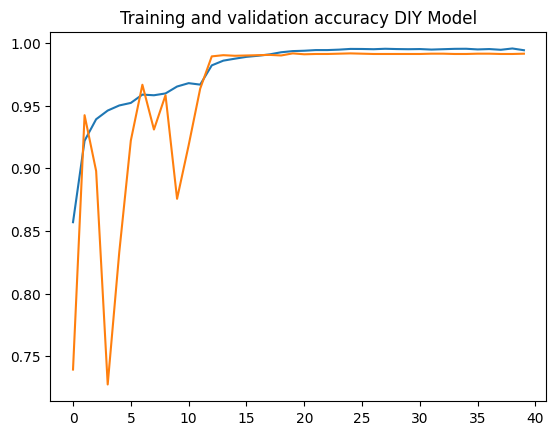

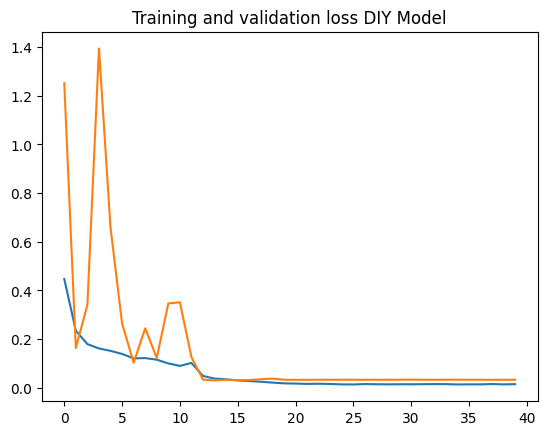

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_2.history['accuracy' ]
val_acc  = history_DenseNet_model_2.history['val_accuracy' ]
loss     = history_DenseNet_model_2.history['loss' ]
val_loss = history_DenseNet_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')

In [ ]:
!zip -r /content/DenseNet_model2_Tomato_Based_Non_Augmented.zip /content/DenseNet_model2_Tomato_Based_Non_Augmented

  adding: content/DenseNet_model2_Tomato_Based_Non_Augmented/ (stored 0%)
  adding: content/DenseNet_model2_Tomato_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/DenseNet_model2_Tomato_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/DenseNet_model2_Tomato_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/DenseNet_model2_Tomato_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/DenseNet_model2_Tomato_Based_Non_Augmented/variables/variables.index (deflated 79%)
  adding: content/DenseNet_model2_Tomato_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/DenseNet_model2_Tomato_Based_Non_Augmented/saved_model.pb (deflated 92%)
